In [1]:
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultitaskMultivariateNormal
from gpytorch.models import ExactGP
from gpytorch.kernels import MultitaskKernel
from gpytorch.means import MultitaskMean
from gpytorch.likelihoods import MultitaskGaussianLikelihood
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def test_multitask(input1, output1, output2):
    class MultitaskGPModel(ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = MultitaskMean(ConstantMean(), num_tasks=2)
            self.covar_module = MultitaskKernel(
                RBFKernel(), num_tasks=2, rank=1
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return MultitaskMultivariateNormal(mean_x, covar_x)
        
    store = pd.DataFrame(output1.numpy(), columns=['Latitude'])
    store['Longitude'] = output2.numpy()
    coordinates = torch.tensor(store[['Latitude', 'Longitude']].values, dtype=torch.float32)

    likelihood = MultitaskGaussianLikelihood(num_tasks=2)
    model = MultitaskGPModel(
        train_x=input1,
        train_y=coordinates,
        likelihood=likelihood,
    )

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()}, 
    ], lr=0.1)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 300
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(input1)
        loss = -mll(output, coordinates)
        loss.backward()
        optimizer.step()

    return model.covar_module.task_covar_module._eval_covar_matrix().detach().numpy()

test_multitask(input1=torch.tensor([[0.0], [1.0], [2.0]]), 
                output1=torch.tensor([[1.0], [2.0], [3.0]]), 
                output2=torch.tensor([[4.0], [50.0], [20.0]]))


array([[2.2100177e-02, 1.1807878e+00],
       [1.1807878e+00, 7.5699196e+01]], dtype=float32)

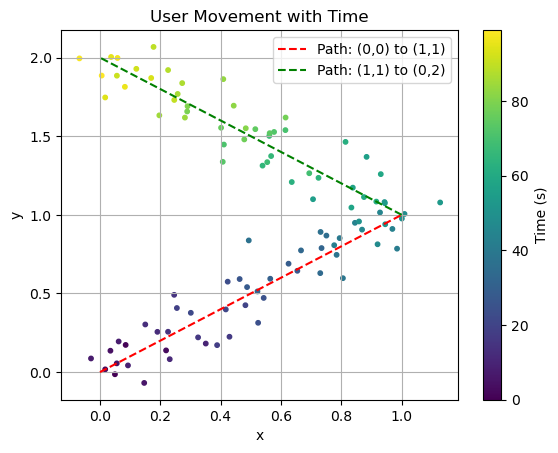

In [3]:
np.random.seed(42)

# number of points to generate for each segment
n_points = 50

time_interval = 1

# Generate data points from (0,0) to (1,1)
start_1 = np.array([0, 0])
end_1 = np.array([1, 1])
points_1 = np.linspace(start_1, end_1, n_points) + np.random.normal(scale=0.1, size=(n_points, 2))

# Generate data points from (1,1) to (0,2)
start_2 = end_1
end_2 = np.array([0, 2])
points_2 = np.linspace(start_2, end_2, n_points) + np.random.normal(scale=0.1, size=(n_points, 2))

all_points = np.vstack([points_1, points_2])

times_1 = np.arange(0, len(points_1) * time_interval, time_interval)
times_2 = np.arange(times_1[-1] + time_interval, times_1[-1] + time_interval + len(points_2) * time_interval, time_interval)
times = np.hstack([times_1, times_2])

plt.scatter(all_points[:, 0], all_points[:, 1], c=times, s=10, cmap='viridis')
plt.plot([0, 1], [0, 1], 'r--', label='Path: (0,0) to (1,1)')
plt.plot([1, 0], [1, 2], 'g--', label='Path: (1,1) to (0,2)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('User Movement with Time')
plt.colorbar(label='Time (s)')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
times_1_tensor = torch.tensor(times_1).view(-1, 1)
times_2_tensor = torch.tensor(times_2).view(-1, 1)
times_tensor = torch.tensor(times).view(-1, 1)
points_1_lat_tensor = torch.tensor(points_1[:,0])
points_1_lng_tensor = torch.tensor(points_1[:,1])
points_2_lat_tensor = torch.tensor(points_2[:,0])
points_2_lng_tensor = torch.tensor(points_2[:,1])
all_points_lat_tensor = torch.tensor(all_points[:,0])
all_points_lng_tensor = torch.tensor(all_points[:,1])

covar_matrices_1 = [test_multitask(input1=times_1_tensor, output1=points_1_lat_tensor, output2=points_1_lng_tensor) for _ in range(50)]
covar_matrices_1 = np.array(covar_matrices_1)

covar_matrices_2 = [test_multitask(input1=times_tensor, output1=all_points_lat_tensor, output2=all_points_lng_tensor) for _ in range(50)]
covar_matrices_2 = np.array(covar_matrices_2)

covar_matrices_3 = [test_multitask(input1=times_2_tensor, output1=points_2_lat_tensor, output2=points_2_lng_tensor) for _ in range(50)]
covar_matrices_3 = np.array(covar_matrices_3)

In [5]:
covar_matrices_1

array([[[0.0728298 , 0.07547008],
        [0.07547008, 0.07835692]],

       [[0.06963938, 0.07255243],
        [0.07255243, 0.07574055]],

       [[0.07477287, 0.07182516],
        [0.07182516, 0.06924522]],

       [[0.0752618 , 0.07628297],
        [0.07628297, 0.07742216]],

       [[0.07526576, 0.07797064],
        [0.07797064, 0.08087541]],

       [[0.07894973, 0.08089089],
        [0.08089089, 0.08304828]],

       [[0.07105817, 0.07195356],
        [0.07195356, 0.07308473]],

       [[0.07404451, 0.07515235],
        [0.07515235, 0.07646815]],

       [[0.0735318 , 0.07390007],
        [0.07390007, 0.07440998]],

       [[0.06506329, 0.06771179],
        [0.06771179, 0.07059519]],

       [[0.07026437, 0.072266  ],
        [0.072266  , 0.07463493]],

       [[0.07418036, 0.07601122],
        [0.07601122, 0.07808719]],

       [[0.07171295, 0.07280293],
        [0.07280293, 0.07411967]],

       [[0.08017347, 0.08126718],
        [0.08126718, 0.08251929]],

       [[0.06632438,

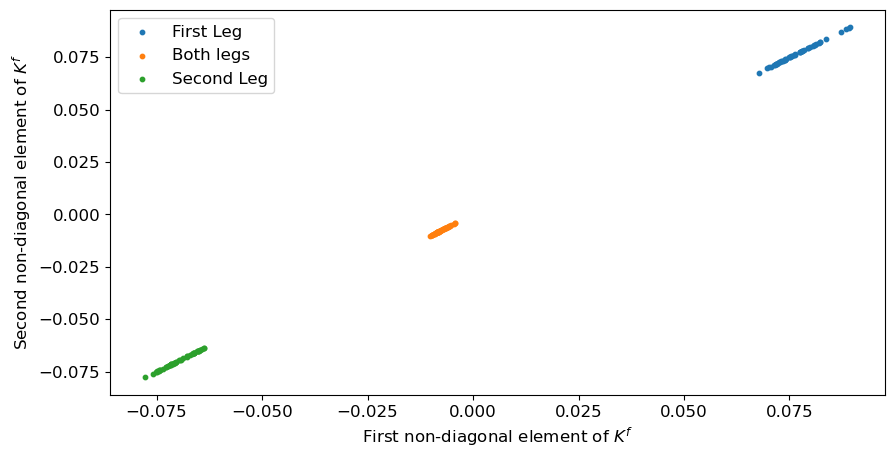

In [6]:
fontsize=12

plt.figure(figsize=(10, 5))
plt.scatter(covar_matrices_1[:, 0, 1], covar_matrices_1[:, 1, 0], label='First Leg', s=10, alpha=1)
plt.scatter(covar_matrices_2[:, 0, 1], covar_matrices_2[:, 1, 0], label='Both legs', s=10, alpha=1)
plt.scatter(covar_matrices_3[:, 0, 1], covar_matrices_3[:, 1, 0], label='Second Leg', s=10, alpha=1)
plt.legend(fontsize=fontsize)
plt.xlabel(f'First non-diagonal element of $K^f$', fontsize=fontsize)
plt.ylabel(f'Second non-diagonal element of $K^f$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

In [7]:
store = pd.DataFrame(all_points_lat_tensor.numpy(), columns=['Latitude'])
store['Longitude'] = all_points_lng_tensor.numpy()
store['Time'] = times_tensor.numpy()

# Convert all to tensors
times_tensor = torch.tensor(store['Time'].values, dtype=torch.float32).view(-1, 1)
coordinates = torch.tensor(store[['Latitude', 'Longitude']].values, dtype=torch.float32)

all_points_lat_tensor = torch.tensor(all_points[:,0], dtype=torch.float32)
all_points_lng_tensor = torch.tensor(all_points[:,1], dtype=torch.float32)

/Users/ekinokos2/mambaforge/envs/gtpy/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


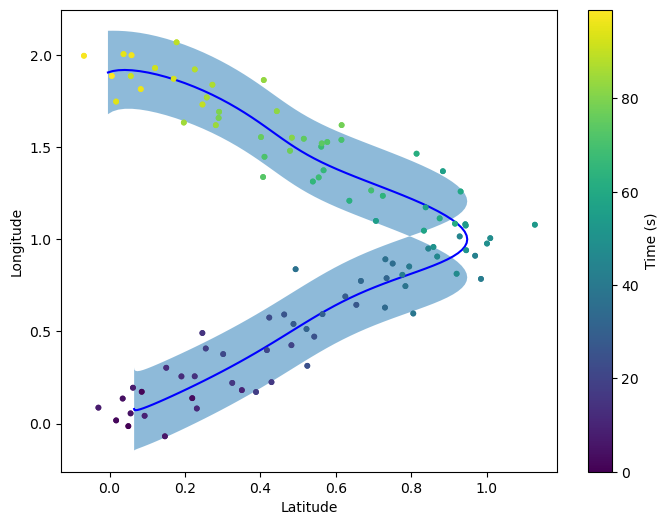

In [8]:
class MultitaskGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = MultitaskMean(gpytorch.means.ConstantMean(), num_tasks=2)
        self.covar_module = MultitaskKernel(
            gpytorch.kernels.ScaleKernel(RBFKernel()), num_tasks=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskMultivariateNormal(mean_x, covar_x)
    
likelihood = MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(
    train_x=times_tensor,
    train_y=coordinates,
    likelihood=likelihood,
)

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
{'params': model.parameters()},
], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 300
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(times_tensor)
    loss = -mll(output, coordinates)
    loss.backward()
    optimizer.step()

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(times_tensor))
    lower, upper = observed_pred.confidence_region()

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(all_points_lat_tensor, all_points_lng_tensor, zorder=10, c=times, s=10, cmap='viridis')
ax.plot(observed_pred.mean[:, 0].numpy(), observed_pred.mean[:, 1].numpy(), 'b')
ax.fill_between(observed_pred.mean[:, 0].numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
plt.colorbar(ax.scatter(all_points_lat_tensor, all_points_lng_tensor, c=times, s=10, cmap='viridis'), label='Time (s)')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()


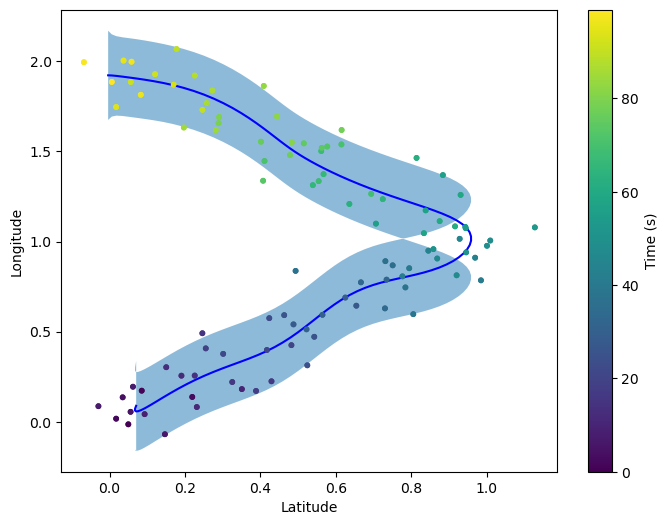

In [9]:
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
lat_model = GPModel(
    train_x=times_tensor,
    train_y=coordinates[:,0],
    likelihood=likelihood,
)

lat_model.train()
likelihood.train()

optimizer = torch.optim.Adam([
{'params': lat_model.parameters()}, 
], lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, lat_model)

training_iter = 300
for i in range(training_iter):
    optimizer.zero_grad()
    output = lat_model(times_tensor)
    loss = -mll(output, coordinates[:,0])
    loss.backward()
    optimizer.step()

long_model = GPModel(
    train_x=times_tensor,
    train_y=coordinates[:,1],
    likelihood=likelihood,
)

long_model.train()
likelihood.train()

optimizer = torch.optim.Adam([
{'params': long_model.parameters()},
], lr=0.1)

training_iter = 300
for i in range(training_iter):
    optimizer.zero_grad()
    output = long_model(times_tensor)
    loss = -mll(output, coordinates[:,1])
    loss.backward()
    optimizer.step()

lat_model.eval()
long_model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_lat = likelihood(lat_model(times_tensor))
    observed_pred_long = likelihood(long_model(times_tensor))

    lower_lat, upper_lat = observed_pred_lat.confidence_region()
    lower_long, upper_long = observed_pred_long.confidence_region()

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(coordinates[:,0], coordinates[:,1], zorder=10, c=times, s=10, cmap='viridis')
ax.plot(observed_pred_lat.mean.numpy(), observed_pred_long.mean.numpy(), 'b')
ax.fill_between(observed_pred_lat.mean.numpy(), lower_long.numpy(), upper_long.numpy(), alpha=0.5)
plt.colorbar(ax.scatter(coordinates[:,0], coordinates[:,1], c=times, s=10, cmap='viridis'), label='Time (s)')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()
